# Frequency Differencing with L2 EK60 Data

- Creators: Rudy Klucik, Veronica Martinez, Charles Anderson and Carrie Wall
- Affiliations: Cooperative Institute for Research in Environmental Sciences ([CIRES](https://cires.colorado.edu/)) and National Oceanic and Atmospheric Admnistration (NOAA) National Centers for Environmental Information ([NCEI](https://www.ncei.noaa.gov/))
- Acknowledgements: Funding support was provided by the NOAA Center for Artificial Intelligence ([NCAI](https://www.noaa.gov/noaa-center-for-artificial-intelligence/)) and [NOAA Fisheries](https://www.fisheries.noaa.gov/)

## Overview
The size and physiological characteristics of marine organisms determine their reflectance properties. An organisms backscatter also depends on the sonar frequency. Frequency differencing of the sonar's volume backscattering strength (Sv) called "dB differencing" is a common analysis technique to help differentiate sources of acoustic scatterers.

This notebook demonstrates the use of frequency differencing on some Level 2 EK60 data.

The Level 2 data can be found here:

*   https://noaa-wcsd-zarr-pds.s3.us-east-1.amazonaws.com/level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr/


The files can be explored by navigating to the following AWS file explorer:

*   https://noaa-wcsd-zarr-pds.s3.amazonaws.com/index.html#level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr/




## Prerequisites
To successfully navigate and use this notebook, you should be familiar with:

- the basics of Python programming such as loading modules, assigning variables, and list/array indexing
- plotting data using matplotlib
- EK60 water-column sonar file formats

## Learning Outcomes
By working through this notebook, you will learn how to:

- access data from an S3 bucket
- read an EK60 file
- use Xarray to read cloud-native Zarr formatted files
- apply frequency differencing to analyze the data
- plot results

## Software
This tutorial uses the Python programming language and packages. We will use:
- boto3 to access data from an S3 bucket
- Zarr to read subsets of data from an S3 store
- Xarray to work with Zarr data for analysis
- Numpy for simple array operations
- Matplotlib to plot data

## Installing and importing libraries

We will first need to install a couple libraries for accessing and processing data.

If you do not already have zarr installed, use the following pip command in the terminal to install it:

> pip install zarr

If you don't already have boto3 installed, use the following pip command:

> pip install boto3

Libraries can be installed as follows:


In [ ]:
%%capture
!pip install boto3
!pip install xarray
!pip install zarr

Next import the libraries:

In [ ]:
import os
import boto3
import zarr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

To access the data we will use the library called "boto3." This is a library that gives you access to a full suite of AWS tools, we are just going to use it to download a file from an S3 bucket. Because this is a public dataset it can be accessed using and anonymous configuration (e.g. the "UNSIGNED" Config below).

In [ ]:
from botocore import UNSIGNED
from botocore.config import Config

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [ ]:
WCSD_BUCKET_NAME = 'noaa-wcsd-zarr-pds'

zarr_file = 'level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr'

## Read Zarr Store data using Python's Xarray

For this tutorial we will read the data directly from an S3 bucket where the data is stored in a cloud-native format called "Zarr."

There are different ways to open data in a Zarr format using Python. While different libraries have different strengths and weaknesses, the library we will use is called "Xarray."

Xarray is a powerful tool for working with scientific data to do analysis and works well with other libraries including Pandas, Numpy and tools such as Dask.

One thing to note about interacting with Zarr stores is that they can represent very large datasets (sometimes hundreds of GB in size) whereas typical data workflows concern only subsets of the data. Zarr is designed to efficiently serve just the subset of data you are interested in, removing the typical requirement for users to download entire datasets before beginning their analysis.



In [ ]:
%%capture
!pip install s3fs
import s3fs

In [ ]:
s3_file_system = s3fs.S3FileSystem(anon=True)

The format of the files we will process follow a format as follows:

> `https://<Bucket Name>.s3.amazonaws.com/data/level_2/<Ship Name>/<Cruise Name>/<Sensor Name>/<Zarr Store>`

For example:

> `https://noaa-wcsd-pds.s3.amazonaws.com/data/level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr`

In [ ]:
bucket_name = 'noaa-wcsd-zarr-pds'

ship_name = 'Bell_M._Shimada'
cruise_name = 'SH1507'
sensor_name = 'EK60'

zarr_store = f'{cruise_name}.zarr'

s3_zarr_store_path = f"{bucket_name}/level_2/{ship_name}/{cruise_name}/{sensor_name}/{zarr_store}"

In [ ]:
print(s3_zarr_store_path)

noaa-wcsd-zarr-pds/level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr


Next use s3fs to directly access the files in the S3 bucket as if you were accessing files that were saved on your filesystem.

In [ ]:
store = s3fs.S3Map(root=s3_zarr_store_path, s3=s3_file_system, check=False)

Now that the "store" knows where the files live, we need to open the Zarr store using the desired library, Xarray.

## Opening a Zarr store with Xarray

We will open the S3 Zarr store using Xarray (the "consolidated" parameter just defines whether we are interested in reading the metadata in a consolidated manner, "None" is the desired value).

In [ ]:
cruise = xr.open_zarr(store=store, consolidated=None)

In [ ]:
cruise

<xarray.Dataset>
Dimensions:    (depth: 2800, time: 3234, frequency: 5)
Coordinates:
  * depth      (depth) float64 nan 0.25 0.5 0.75 1.0 ... 699.2 699.5 699.8 700.0
  * frequency  (frequency) float32 1.8e+04 3.8e+04 7e+04 1.2e+05 2e+05
  * time       (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-0...
Data variables:
    Sv         (depth, time, frequency) float32 dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    latitude   (time) float32 dask.array<chunksize=(512,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(512,), meta=np.ndarray>
Attributes:
    processing_software_name:     echofish
    processing_software_version:  0.0.1
    processing_time:              2023-10-01T18:08:01Z

## Accessing a Level 2 Zarr Store

We can see that a Level 2 Zarr store is composed of dimensions, coordinates, data variables, indices, and has some associated attributes.

The main data in these level 2 Zarr stores is the acoustic measurement of volume backscattering strength denoted as "Sv", which has a unit of dB and is organized into a multidimensional Xarray
DataArray. Sv by frequency along with time and depth are used to create the echograms, a visual representation of the sonar data.

In [ ]:
cruise.Sv

<xarray.DataArray 'Sv' (depth: 2800, time: 3234, frequency: 5)>
dask.array<open_dataset-Sv, shape=(2800, 3234, 5), dtype=float32, chunksize=(512, 512, 1), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 nan 0.25 0.5 0.75 1.0 ... 699.2 699.5 699.8 700.0
  * frequency  (frequency) float32 1.8e+04 3.8e+04 7e+04 1.2e+05 2e+05
  * time       (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-0...
Attributes:
    long_name:  Volume backscattering strength (Sv re 1 m-1)
    units:      dB

The coordinates of the Sv data are defined by a depth value (meters below the sea surface), time (defined by Pandas datetime64[ns]), and frequency (data are typically measured across several frequencies meant for intercomparison).

In [ ]:
cruise.coords

Coordinates:
  * depth      (depth) float64 nan 0.25 0.5 0.75 1.0 ... 699.2 699.5 699.8 700.0
  * frequency  (frequency) float32 1.8e+04 3.8e+04 7e+04 1.2e+05 2e+05
  * time       (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-0...

In addition to the above we also define DataArrays for spatiotemporal information associated with each Sv measurement. This includes the already defined "time" as well as "latitude" and "longitude." They can each be accessed using the dot operator e.g.:

In [ ]:
cruise.time

<xarray.DataArray 'time' (time: 3234)>
array(['2015-07-19T19:08:39.063712768', '2015-07-19T19:08:40.360587776',
       '2015-07-19T19:08:41.641838080', ..., '2015-07-19T20:04:38.676898816',
       '2015-07-19T20:04:39.692524032', '2015-07-19T20:04:40.723773952'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-07-...
Attributes:
    long_name:      Timestamp of each ping
    standard_name:  time

In [ ]:
cruise.latitude

<xarray.DataArray 'latitude' (time: 3234)>
dask.array<open_dataset-latitude, shape=(3234,), dtype=float32, chunksize=(512,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-07-...
Attributes:
    long_name:  Latitude
    units:      degrees_north

In [ ]:
cruise.longitude

<xarray.DataArray 'longitude' (time: 3234)>
dask.array<open_dataset-longitude, shape=(3234,), dtype=float32, chunksize=(512,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-07-...
Attributes:
    long_name:  Longitude
    units:      degrees_east

These coordinate conventions allow us the ability to quickly subset or sample the data in different ways so that it can be selected by frequency, time, depth, or GPS coordinates.

In [ ]:
cruise.depth

<xarray.DataArray 'depth' (depth: 2800)>
array([       nan, 2.5000e-01, 5.0000e-01, ..., 6.9950e+02, 6.9975e+02,
       7.0000e+02])
Coordinates:
  * depth    (depth) float64 nan 0.25 0.5 0.75 1.0 ... 699.2 699.5 699.8 700.0
Attributes:
    long_name:  Depth below surface
    units:      m

The 'depth' defines gridded measurements of Sv values and is defined in meters below the sea surface starting at 0 meters, increasing going downward. There are typically multiple 'frequencies' such as 18 kHz, 38 kHz, 70 kHz, 120 kHz, and 200 kHz. The frequencies that are found in a file depends on the instrumentation the ship was outfitted with and the underlying science goals of the mission collecting the data.

Some of the date and depth ranges and the frequencies in the datset are:

In [ ]:
print(f"Date range: '{cruise.time.values[0]}' to '{cruise.time.values[-1]}'\n")

print(f"Maximum depth: '{cruise.depth.values[-1]}' measured in meters.\n")

print(f"Frequencies: {cruise.frequency.values} measured in Hz.\n")

Date range: '2015-07-19T19:08:39.063712768' to '2015-07-19T20:04:40.723773952'

Maximum depth: '700.0' measured in meters.

Frequencies: [ 18000.  38000.  70000. 120000. 200000.] measured in Hz.



## Data Chunking Format

One thing to take note of as you begin to interact with Zarr stores is that a store is actually not a singular file but rather a directory consisting of [typically] thousands of smaller files to enable quick computation on subsets of the data.

If you are interested in the underlying implementation see [this video](https://www.youtube.com/watch?v=qo0qqE7WGLQ&t=235s) for more information.

The "chunk" size of the Sv data can be found as follows:

In [ ]:
cruise.Sv.chunk

<bound method DataArray.chunk of <xarray.DataArray 'Sv' (depth: 2800, time: 3234, frequency: 5)>
dask.array<open_dataset-Sv, shape=(2800, 3234, 5), dtype=float32, chunksize=(512, 512, 1), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 nan 0.25 0.5 0.75 1.0 ... 699.2 699.5 699.8 700.0
  * frequency  (frequency) float32 1.8e+04 3.8e+04 7e+04 1.2e+05 2e+05
  * time       (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-0...
Attributes:
    long_name:  Volume backscattering strength (Sv re 1 m-1)
    units:      dB>

where the value is 512 by 512 by 1.

Subsetting on one hour worth of data near an area of interest. We'll define select_times from 19:00 to 20:00 on July 19th 2015.

In [ ]:
# roughly covering the raw files from SaKe2015-D20150719-T193412.raw to SaKe2015-D20150719-T195842.raw
start_time = np.datetime64('2015-07-19T19:00:00')
end_time = np.datetime64('2015-07-19T20:00:00')

select_times = (cruise.time > start_time) & (cruise.time < end_time)

We can then use this slice of select_times to select the Sv values for the specific subset of time. Additional subsetting can also be added to the query, for example we can additionally subset by defining a selected frequency. The example below selects 18 kHz for the time interval of interest and store this in Sv_18 (drop=True means that the coordinate labels that do not meet the condition are not just masked but also dropped from the result).

In [ ]:
Sv_38 = cruise.sel(frequency=38000).where((select_times), drop=True).Sv
print(Sv_38)

<xarray.DataArray 'Sv' (depth: 2800, time: 2959)>
dask.array<where, shape=(2800, 2959), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 nan 0.25 0.5 0.75 1.0 ... 699.2 699.5 699.8 700.0
    frequency  float32 3.8e+04
  * time       (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-0...
Attributes:
    long_name:  Volume backscattering strength (Sv re 1 m-1)
    units:      dB


## Plotting the Echograms

In [ ]:
Sv_38

<xarray.DataArray 'Sv' (depth: 2800, time: 2959)>
dask.array<where, shape=(2800, 2959), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 nan 0.25 0.5 0.75 1.0 ... 699.2 699.5 699.8 700.0
    frequency  float32 3.8e+04
  * time       (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-0...
Attributes:
    long_name:  Volume backscattering strength (Sv re 1 m-1)
    units:      dB

In [ ]:
type(Sv_38)

xarray.core.dataarray.DataArray

In [ ]:
print(f"min: {np.nanmin(Sv_38)}, max: {np.nanmax(Sv_38)}")

min: -153.65846252441406, max: 1.7436072826385498


Text(0.5, 1.0, 'Sv 38 kHz')

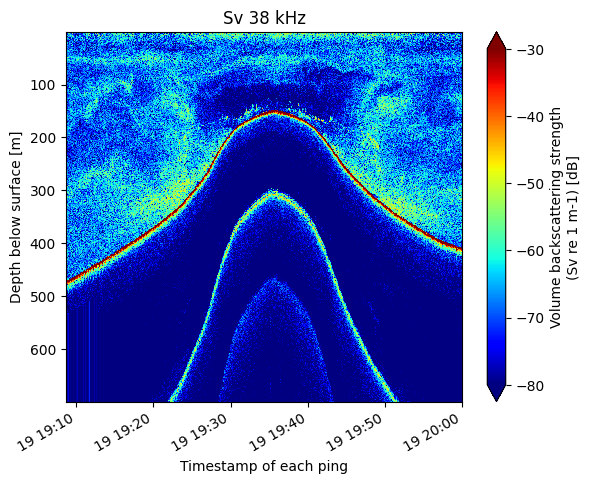

In [ ]:
Sv_38.dropna(dim='depth').plot(yincrease=False, cmap='jet', vmin=-80, vmax=-30)

plt.title(f"Sv 38 kHz")

The data in the plot above shows a detected bottom as a ship crosses above a smooth ridge. Beneath the seabed are two harmonics we would like to omit from the plot. We can begin to do that by just plotting data between 0 and 500 meters of depth.

In [ ]:
start_depth = 0
end_depth = 500

select_depths = (cruise.depth > start_depth) & (cruise.depth < end_depth)

In [ ]:
Sv_38_subset = Sv_38.where((select_depths), drop=True)

Now when we plot the data it is subsetted to less than 500 meters of depth.

Text(0.5, 1.0, 'Sv 38 kHz')

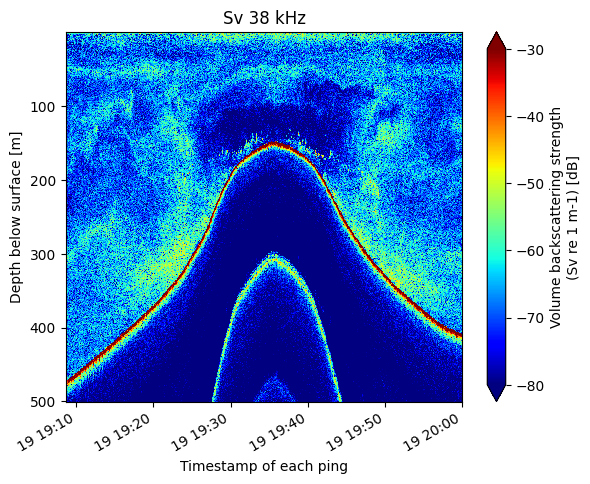

In [ ]:
Sv_38_subset.plot(yincrease=False, cmap='jet', vmin=-80, vmax=-30)
plt.title(f"Sv 38 kHz")

We can also select the corresponding data for 120 and 200 kHz and store them in seperate variables

In [ ]:
Sv_18 = cruise.sel(frequency=18000).where((select_times) & (select_depths), drop=True).Sv
Sv_120 = cruise.sel(frequency=120000).where((select_times) & (select_depths), drop=True).Sv
Sv_200 = cruise.sel(frequency=200000).where((select_times) & (select_depths), drop=True).Sv

For comparison, let's see the 120 kHz echogram with the same depth bounds.

In [ ]:
Sv_120_subset = Sv_120.where((select_depths), drop=True)

Text(0.5, 1.0, 'Sv 120 kHz')

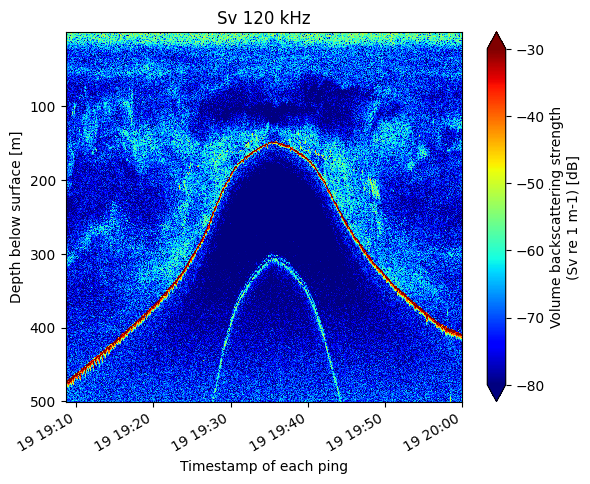

In [ ]:
Sv_120_subset.plot(yincrease=False, cmap='jet', vmin=-80, vmax=-30)
plt.title(f"Sv 120 kHz")

## Frequency Differencing

Frequency differencing is simply subtracting the Sv values at one frequency from those at another frequency. Here we will compare the 120 kHz data selected above to the corresponding data at 38 kHz stored and plot the results. You can compare different frequencies by editing the code below and re-running this step.

In [ ]:
first_freq_array = Sv_120
first_freq = int(first_freq_array.frequency.values/1000)

second_freq_array = Sv_38
second_freq = int(second_freq_array.frequency.values/1000)

Sv_select_diff = first_freq_array - second_freq_array

In [ ]:
Sv_select_diff = Sv_select_diff.dropna(dim='depth')

Text(0.5, 1.0, 'Sv difference between 120 kHz - 38 kHz')

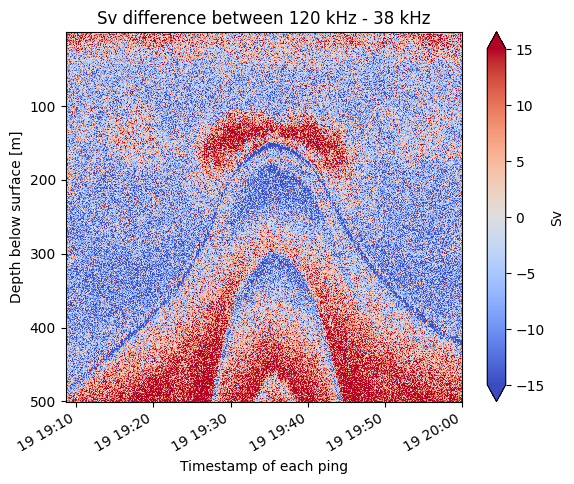

In [ ]:
Sv_select_diff.plot(yincrease=False, vmin=-15, vmax=15, cmap="coolwarm") # updated -rk
plt.title(f"Sv difference between {first_freq} kHz - {second_freq} kHz")

Positive values (red colors) found along top of the ridge, between 100 and 200 meters of depth, and near the surface show stronger backscatter resulting from the 120 kHz transducer. This likely indicates the presence of zooplankton. Negative values (blue colors) show where scattering was greater from the 38 kHz transducer.

# Data statement
All data used in this notebook are publicly available

The Level 2 data can be found here:

*   https://noaa-wcsd-zarr-pds.s3.us-east-1.amazonaws.com/level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr/


The files can be explored by navigating to the following AWS file explorer:

*   https://noaa-wcsd-zarr-pds.s3.amazonaws.com/index.html#level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr/


# References

* Lawson, G.L., Wiebe, P.H., Stanton, T.K. and Ashjian, C.J., 2008. Euphausiid distribution along the Western Antarctic Peninsula—Part A: development of robust multi-frequency acoustic techniques to identify euphausiid aggregations and quantify euphausiid size, abundance, and biomass. Deep Sea Research Part II: Topical Studies in Oceanography, 55(3-4), pp.412-431. https://doi.org/10.1016/j.dsr2.2007.11.010   
* Lee, Wu-Jung, Nguyen, Kavin, Setiawan, Landung, Mayorga, Emilio, Reyes, Brandon, Majeed, Imran, & Staneva, Valentina. (2023). echopype (v0.8.1). Zenodo. https://doi.org/10.5281/zenodo.8312077
* Madureira, L.S., Everson, I. and Murphy, E.J., 1993. Interpretation of acoustic data at two frequencies to discriminate between Antarctic krill (Euphausia superba Dana) and other scatterers. Journal of plankton research, 15(7), pp.787-802.
* Wall, C.C., Jech, J.M. and McLean, S.J., 2016. Increasing the accessibility of acoustic data through global access and imagery. ICES Journal of Marine Science, 73(8), pp.2093-2103.

# Metadata
- Language / packages(s):
 - Language: Python
 - Packages: Boto, Xarray, Zarr

- Scientific domain:
 - Fisheries acoustics

- Application keywords:
 - Sonar processing

- Geophysical keywords
 - Fish
 - Zooplankton
 - Seafloor

# License
## Software and Content Description License
Software code created by U.S. Government employees is not subject to copyright in the United States (17 U.S.C. §105). The United States/Department of Commerce reserve all rights to seek and obtain copyright protection in countries other than the United States for Software authored in its entirety by the Department of Commerce. To this end, the Department of Commerce hereby grants to Recipient a royalty-free, nonexclusive license to use, copy, and create derivative works of the Software outside of the United States.

# Disclaimer
This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.